# Malaria Classification Project Overview

## Introduction

Ce projet se concentre sur le développement d'un modèle d'apprentissage profond pour la classification des images de cellules du paludisme. Le paludisme, une maladie potentiellement mortelle causée par le parasite Plasmodium, est un problème de santé mondial majeur. En 2020 seulement, on a recensé environ 247 millions de cas de paludisme dans le monde, entraînant environ 619 000 décès, la majorité survenant en Afrique subsaharienne. - [WHO](https://www.who.int/news-room/questions-and-answers/item/malaria?gclid=CjwKCAiAu9yqBhBmEiwAHTx5pyt9CdR0zouYdVCrYMq35x1vuxXRecc_bQx9fybnL3kjY6laCBXtQBoC0_QQAvD_BwE)

## Objective

L'objectif de ce projet est de créer un modèle capable de distinguer deux classes clés :

- **Uninfected Cells:** Healthy red blood cells without malaria infection.
- **Parasitized Cells:** Red blood cells infected with Plasmodium parasites.

## Dataset

The dataset comprises a collection of images depicting both uninfected and parasitized cells. Sourced from the official NIH Malaria Datasets, it contains a total of `27,558` images.

## Methodology

Nous exploiterons des techniques d'apprentissage profond, notamment les réseaux de neurones convolutifs (CNN), pour former un modèle capable d'apprendre et de différencier automatiquement les caractéristiques associées aux cellules infectées et non infectées. Le modèle sera entraîné sur un jeu de données étiqueté et évalué sur un jeu de test distinct afin d'évaluer ses performances de classification.

## Significance

La classification automatisée des cellules du paludisme pourrait accélérer le processus de diagnostic, notamment dans les régions où l'accès aux soins de santé est limité. La mise en œuvre réussie de ce modèle pourrait contribuer à un diagnostic du paludisme plus efficace et plus précis, aidant ainsi les professionnels de santé à proposer des interventions rapides et ciblées.

Let's embark on this journey to develop a robust deep learning model for malaria cell classification!

## Acknowledgements
- [Malaria Cell Images Dataset](https://www.kaggle.com/datasets/iarunava/cell-images-for-detecting-malaria/data)
- [NIH Malaria Datasets](https://ceb.nlm.nih.gov/repositories/malaria-datasets/)

# Import important libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import PIL
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Input, Conv2D, MaxPooling2D, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import img_to_array, load_img, array_to_img
from tensorflow.keras.applications.vgg19 import VGG19
import seaborn as sns

C:\Users\congo\anaconda3\envs\my_tensorflow_env\lib\site-packages\h5py\__init__.py:36: UserWarning: h5py is running against HDF5 1.14.5 when it was built against 1.14.2, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


In [2]:
from  pathlib import Path 
path = Path(r"C:\Users\congo\Desktop\cell_images")
data_dir = path

In [3]:
image_count = len(list(data_dir.glob('*/*.png')))
print(image_count)

27558


In [4]:
uninfected = list(data_dir.glob("Uninfected/*"))
parasitized = list(data_dir.glob("Parasitized/*"))
print("Number of uninfected cells", len(uninfected))
print("Number of uninfected cells", len(parasitized))

Number of uninfected cells 13780
Number of uninfected cells 13780


# Displaying some examples

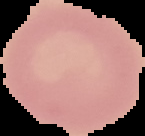

In [5]:
PIL.Image.open(uninfected[1])

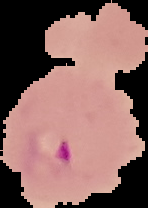

In [6]:
PIL.Image.open(parasitized[1])

In [7]:
batch_size = 32
img_height = 150
img_width = 150

In [8]:
image_gen = ImageDataGenerator(
    rotation_range=40,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split = 0.3,
    rescale = 1/255
)

In [9]:
training_data = image_gen.flow_from_directory(
    data_dir,
    subset = "training",
    class_mode="binary",
    target_size = (img_width, img_height),
    batch_size = batch_size
)

validation_data = image_gen.flow_from_directory(
    data_dir,
    subset = "validation",
    class_mode="binary",
    target_size = (img_width, img_height),
    batch_size = batch_size
)

Found 38583 images belonging to 3 classes.
Found 16533 images belonging to 3 classes.


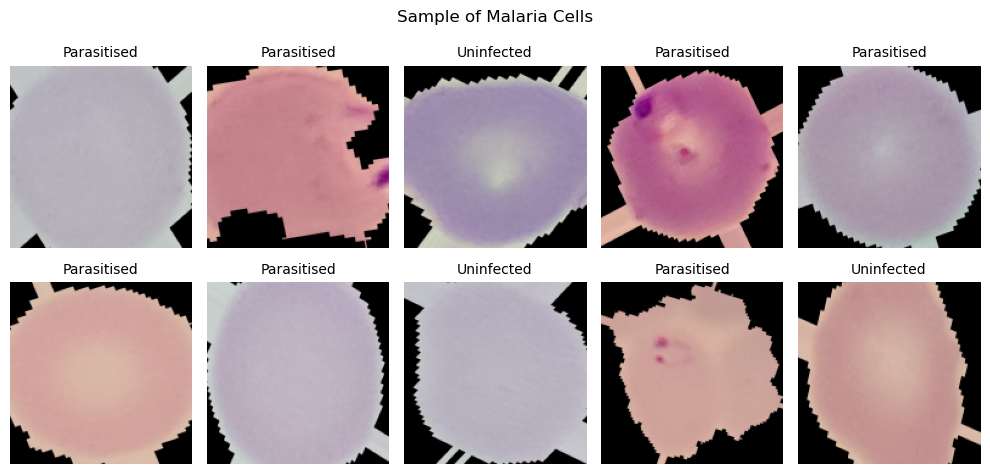

In [10]:
X_train, y_train = next(training_data)

fig = plt.figure(figsize=(10, 5))

for i in range(10):
    ax = fig.add_subplot(2, 5, i+1)
    ax.imshow(X_train[i])
    ax.axis("off")
    ax.set_title("Uninfected" if y_train[i] == 1 else "Parasitised", fontsize=10)
fig.suptitle("Sample of Malaria Cells")
plt.tight_layout()

# Building 'Home-Made' Network

## Our model Architecture

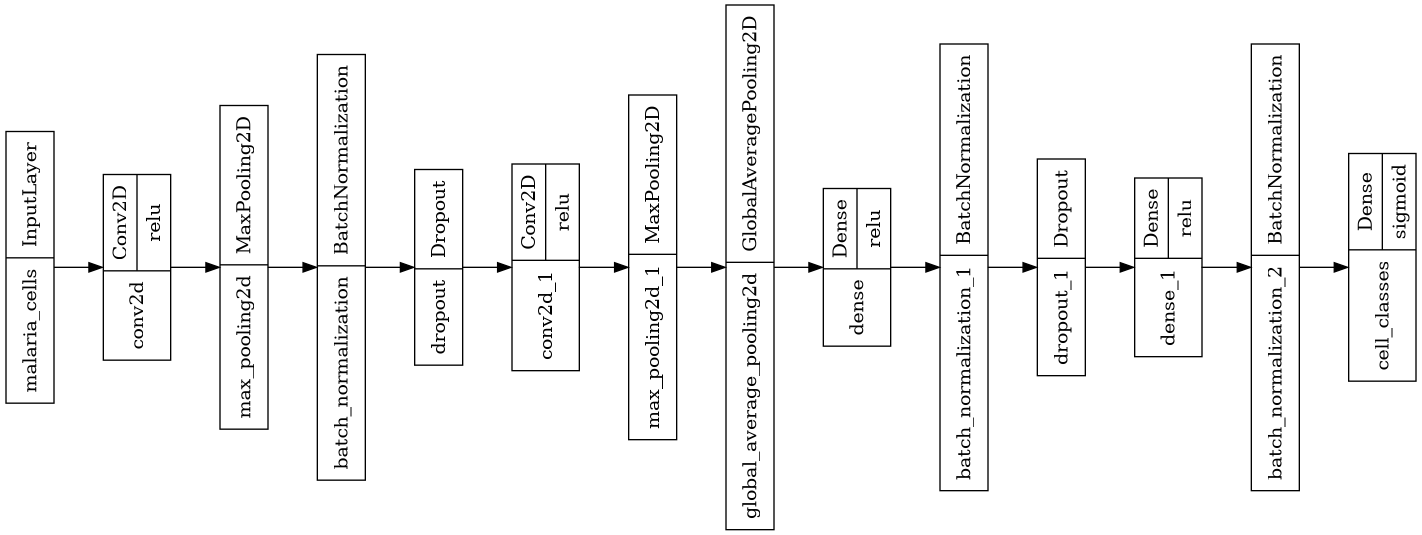

In [11]:
input = Input(shape = (img_width, img_height, 3), dtype=tf.float32, name="malaria_cells")
X = Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding="same", activation="relu")(input)
X = MaxPooling2D(pool_size = (2, 2))(X)
X = BatchNormalization()(X)
X = Dropout(0.3)(X)
X = Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding="same", activation="relu")(X)
X = MaxPooling2D(pool_size = (2, 2))(X)

X = GlobalAveragePooling2D()(X)
X = Dense(512, activation="relu")(X)
X = BatchNormalization()(X)
X = Dropout(0.3)(X)
X = Dense(256, activation="relu")(X)
X = BatchNormalization()(X)
output = Dense(1, activation="sigmoid", name="cell_classes")(X)

model = Model(inputs=input, outputs=output)

In [12]:
plot_model(model, "model.png", show_layer_activations=True)
model.summary()

You must install pydot (`pip install pydot`) for `plot_model` to work.


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ malaria_cells (InputLayer)           │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 150, 150, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 75, 75, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 75, 75, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 75, 75, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 75, 75, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 37, 37, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 64)                  │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │          33,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cell_classes (Dense)                 │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 206,913 (808.25 KB)

 Trainable params: 205,249 (801.75 KB)

 Non-trainable params: 1,664 (6.50 KB)

In [13]:
optim = tf.keras.optimizers.Adam()
loss = tf.keras.losses.BinaryCrossentropy()

model.compile(optimizer=optim, loss=loss, metrics=["accuracy"])

## Training our model

In [14]:
epochs = 5

checkpoint_filepath = '/tmp/checkpoint.weights.h5'  # Ajout de l'extension correcte
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    patience=3, 
    min_delta=1e-3, 
    restore_best_weights=True
)

history = model.fit(
    training_data, 
    epochs=epochs, 
    validation_data=validation_data, 
    callbacks=[model_checkpoint_callback, early_stopping]
)


C:\Users\congo\anaconda3\envs\my_tensorflow_env\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 2814s 2s/step - accuracy: 0.2595 - loss: -14.4829 - val_accuracy: 0.2500 - val_loss: -229.7967
Epoch 2/5
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 1934s 2s/step - accuracy: 0.2622 - loss: -341.3228 - val_accuracy: 0.2527 - val_loss: 133.4642
Epoch 3/5
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 1742s 1s/step - accuracy: 0.3340 - loss: -1684.9214 - val_accuracy: 0.2610 - val_loss: 283.6942
Epoch 4/5
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 1770s 1s/step - accuracy: 0.3444 - loss: -3457.7861 - val_accuracy: 0.2499 - val_loss: -252.6987
Epoch 5/5
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 1825s 2s/step - accuracy: 0.3401 - loss: -5587.8618 - val_accuracy: 0.2499 - val_loss: -428.6414


In [37]:
model.save("final_model_malaria.h5")


In [38]:
model.save("malaria-cnn-v1.keras")

In [15]:
model.evaluate(validation_data)

517/517 ━━━━━━━━━━━━━━━━━━━━ 273s 529ms/step - accuracy: 0.2495 - loss: -388.2181


[-441.3907775878906, 0.2498639076948166]

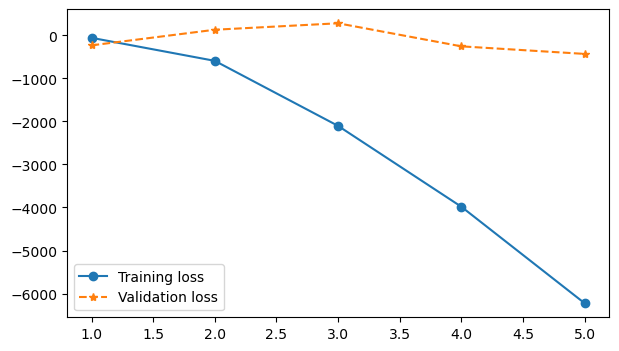

In [16]:
plt.figure(figsize=(7, 4))
ax = plt.axes()
ax.plot(range(1, epochs+1), history.history["loss"], marker="o", label="Training loss")
ax.plot(range(1, epochs+1), history.history["val_loss"], marker="*", ls="--", label="Validation loss")
ax.legend()
plt.show()

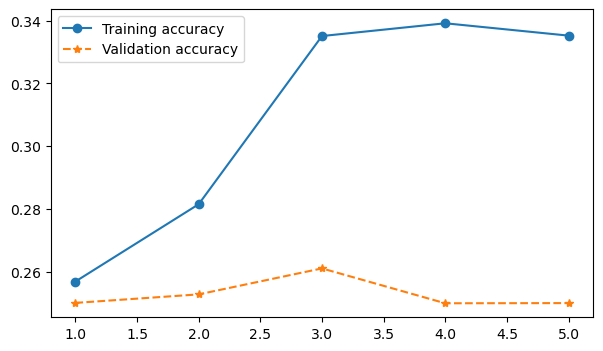

In [19]:
plt.figure(figsize=(7, 4))
ax = plt.axes()
ax.plot(range(1, epochs+1), history.history["accuracy"], marker="o", label="Training accuracy")
ax.plot(range(1, epochs+1), history.history["val_accuracy"], marker="*", ls="--", label="Validation accuracy")
ax.legend()
plt.show()

In [20]:
y_pred_proba = model.predict(validation_data).flatten()
y_pred_classes = (y_pred_proba >= 0.5).astype(np.int32)

517/517 ━━━━━━━━━━━━━━━━━━━━ 225s 436ms/step


In [21]:
def evaluate_ramdom_image(path, ax):
    image = load_img(str(path), target_size=(img_width, img_height))
    img_arr = img_to_array(image)
    img_arr /= 255
    pred = model.predict(img_arr.reshape(1, *img_arr.shape), verbose=0).flatten()
    label = "Parasitised" if pred < 0.5 else "Uninfected"
    ax.imshow(img_arr, vmin=1, vmax=1)
    ax.set_title(f"{label} - {pred[0]:.2%}", size=10)
    ax.axis("off")
    # plt.show()

In [22]:
parasitized_path = list(data_dir.glob("Parasitized/*"))
uninfected_path = list(data_dir.glob("Uninfected/*"))

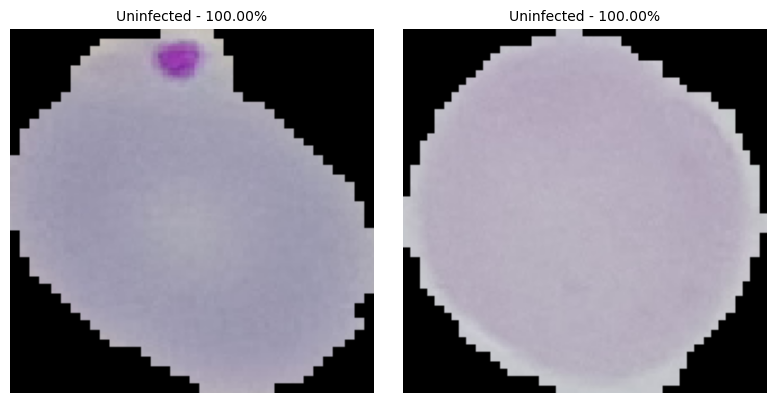

In [26]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
index = np.random.randint(len(parasitized_path))
evaluate_ramdom_image(parasitized_path[index], ax1)
evaluate_ramdom_image(uninfected_path[index], ax2)
plt.tight_layout()

---
# Using Transfer Learning -- VGG19

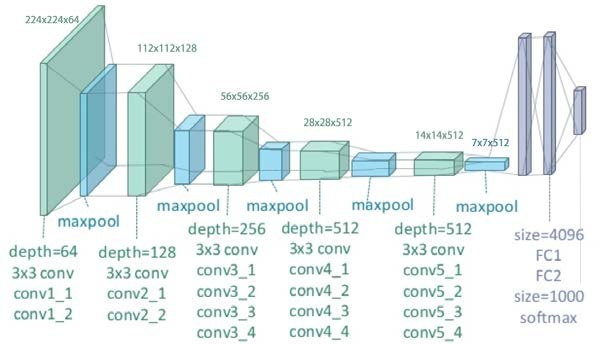

Source: [researchgate](https://www.researchgate.net/figure/llustration-of-the-network-architecture-of-VGG-19-model-conv-means-convolution-FC-means_fig2_325137356)

In [25]:
base_model = VGG19(weights="imagenet", include_top=False, input_shape=(img_width, img_height, 3))
base_model.trainable = False

base_model.summary()

Model: "vgg19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 150, 150, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 150, 150, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 75, 75, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 75, 75, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 75, 75, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 37, 37, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 37, 37, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 37, 37, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 37, 37, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 37, 37, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 18, 18, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 18, 18, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 18, 18, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 18, 18, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 18, 18, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 9, 9, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 20,024,384 (76.39 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 20,024,384 (76.39 MB)

In [26]:
input = Input(shape=(img_width, img_height, 3), dtype=tf.float32)
vgg_model = base_model(input)
X = Flatten()(vgg_model)
output = Dense(1, activation="sigmoid", name="cell_classes")(X)

model_2 = Model(inputs=input, outputs=output)
model_2.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vgg19 (Functional)                   │ (None, 4, 4, 512)           │      20,024,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cell_classes (Dense)                 │ (None, 1)                   │           8,193 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,032,577 (76.42 MB)

 Trainable params: 8,193 (32.00 KB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [27]:
optim = tf.keras.optimizers.Adam()
loss = tf.keras.losses.BinaryCrossentropy()

model_2.compile(optimizer=optim, loss=loss, metrics=["accuracy"])

In [28]:
epochs = 5
early_stopping = tf.keras.callbacks.EarlyStopping(patience=3, min_delta=1e-3, restore_best_weights=True)

history = model_2.fit(training_data, epochs=epochs, validation_data=validation_data, callbacks=[early_stopping])

Epoch 1/5
603/603 ━━━━━━━━━━━━━━━━━━━━ 6542s 11s/step - accuracy: 0.8027 - loss: 0.4234 - val_accuracy: 0.8761 - val_loss: 0.3258
Epoch 2/5
603/603 ━━━━━━━━━━━━━━━━━━━━ 59154s 98s/step - accuracy: 0.8956 - loss: 0.2660 - val_accuracy: 0.8785 - val_loss: 0.3034
Epoch 3/5
603/603 ━━━━━━━━━━━━━━━━━━━━ 3947s 7s/step - accuracy: 0.9066 - loss: 0.2475 - val_accuracy: 0.8797 - val_loss: 0.2977
Epoch 4/5
603/603 ━━━━━━━━━━━━━━━━━━━━ 4245s 7s/step - accuracy: 0.9160 - loss: 0.2267 - val_accuracy: 0.8906 - val_loss: 0.2749
Epoch 5/5
603/603 ━━━━━━━━━━━━━━━━━━━━ 4217s 7s/step - accuracy: 0.9168 - loss: 0.2231 - val_accuracy: 0.8975 - val_loss: 0.2698


In [29]:
model_2.evaluate(validation_data)

259/259 ━━━━━━━━━━━━━━━━━━━━ 1398s 5s/step - accuracy: 0.9037 - loss: 0.2653


[0.2658699154853821, 0.9024921655654907]

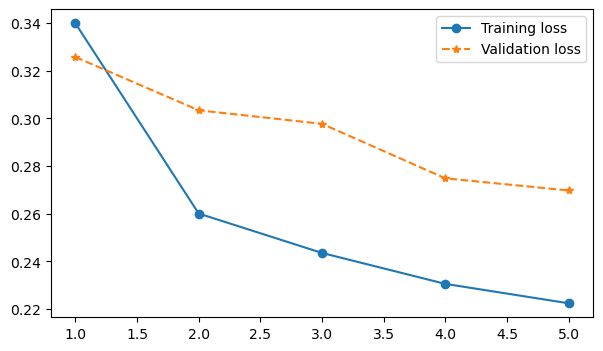

In [30]:
plt.figure(figsize=(7, 4))
ax = plt.axes()
ax.plot(range(1, epochs+1), history.history["loss"], marker="o", label="Training loss")
ax.plot(range(1, epochs+1), history.history["val_loss"], marker="*", ls="--", label="Validation loss")
ax.legend()
plt.show()

## **Our home-made model is performing better than VGG19**

Thank You